The purpose of this notebook is to take all output artifacts from scenes in the experiements: 2021-05-12-BJ-PF-H2B-4OHT-AfterSort and to process them for downstream analysis. These output artifacts are generated by the Fiji custom plugin: CUSTOM PROCESS, and then fed into TrackMate for blob detection and particle linking. 

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from importlib import reload
import time
from datetime import datetime

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# local import
sys.path.append("../")
from utils.trackmate import dataEngineering as _tm
from utils.visualization import generalPlots as _plot
from utils.trackmate import spatialAnalysis as _stat

/home/cstansbu/.local/lib/python3.8/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
"""
combine all outputs into a single dataframe
"""

LOW_INTENSITY_QUANTILE = 0.6

reload(_tm)
ROOT = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/outputs/"

df_list = []

for _dir in os.listdir(ROOT):
    dir_path = f"{ROOT}{_dir}/"
    start = time.time()
    data = _tm.load_trackmate_dir(dir_path)
    df = _tm.merge_tracks_and_all(data)
    df = _tm.clean_up_trackSpots(df, quantile=LOW_INTENSITY_QUANTILE)
    df['TRACK_ID'] = f"{_dir}_" + df['TRACK_ID'].astype(str)
    df['SCENE'] = _dir
    end = time.time()
    print(f"{_dir} took {(end-start)/60:.3f} mins - {len(df)} rows")
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)
print(df.shape)
df.head()
    

C4 took 0.196 mins - 545331 rows
D7 took 0.177 mins - 512663 rows
C7 took 0.148 mins - 431302 rows
B3 took 0.162 mins - 468385 rows
D3 took 0.107 mins - 301432 rows
B4 took 0.159 mins - 487582 rows
C5 took 0.168 mins - 481364 rows
C3 took 0.151 mins - 453775 rows
D6 took 0.109 mins - 347463 rows
D5 took 0.121 mins - 382821 rows
B5 took 0.171 mins - 528405 rows
(4940523, 70)


,Label_x,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,TOTAL_ABSOLUTE_ANGLE_YZ,TOTAL_ABSOLUTE_ANGLE_ZX,STEP,NORMED_STEP,MEAN_INTENSITY01_SCALED,MEAN_INTENSITY02_SCALED,MEAN_INTENSITY03_SCALED,MEAN_INTENSITY04_SCALED,MEAN_INTENSITY_SCALED,SCENE
0,ID23463,23463,C4_0,2.349,429.497,1836.179,0,0.000,0,10,...,3.142,-1.571,0,0.000000,0.0,NaN,0.0,0.838258,NaN,C4
1,ID8192,8192,C4_0,2.895,432.123,1832.823,0,1337.248,1,10,...,3.142,-1.571,1,0.000047,0.0,NaN,0.0,0.000000,NaN,C4
2,ID13445,13445,C4_0,2.326,431.302,1827.591,0,2674.496,2,10,...,3.142,-1.571,2,0.000093,0.0,NaN,0.0,0.000000,NaN,C4
3,ID3542,3542,C4_0,2.646,432.208,1824.476,0,4011.744,3,10,...,3.142,-1.571,3,0.000140,0.0,NaN,1.0,0.742561,NaN,C4
4,ID17874,17874,C4_0,2.345,434.819,1822.808,0,5348.992,4,10,...,3.142,-1.571,4,0.000187,0.0,NaN,0.0,0.722367,NaN,C4


In [3]:
"""
make a back up to speed up development
"""

df2 = df.copy()

In [4]:
"""
rename some columns
"""

new_names = {
    'MEAN_INTENSITY01' : 'MEAN_GREEN_INTENSITY' ,
    'MEAN_INTENSITY02' : 'MEAN_BLUE_INTENSITY' ,
    'MEAN_INTENSITY03' : 'MEAN_RED_INTENSITY' ,
    'MEAN_INTENSITY04' : 'MEAN_OBLIQUE_INTENSITY' ,
    'MEAN_TRACK_INTENSITY01' : 'MEAN_GREEN_TRACK_INTENSITY' ,
    'MEAN_TRACK_INTENSITY02' : 'MEAN_BLUE_TRACK_INTENSITY',
    'MEAN_TRACK_INTENSITY03' : 'MEAN_RED_TRACK_INTENSITY',
    'MEAN_TRACK_INTENSITY04' : 'MEAN_OBLIQUE_TRACK_INTENSITY',
    'MEAN_INTENSITY01_SCALED' :  'MEAN_GREEN_INTENSITY_SCALED',
    'MEAN_INTENSITY02_SCALED' :  'MEAN_BLUE_INTENSITY_SCALED',
    'MEAN_INTENSITY03_SCALED' :  'MEAN_RED_INTENSITY_SCALED',
    'MEAN_INTENSITY04_SCALED' :  'MEAN_OBLIQUE_INTENSITY_SCALED',
    'Label_x' : 'LABEL',
}


df = df.rename(columns=new_names)
df = df.drop(['Label_y'], axis=1)
print(df.shape)
# list(df.columns)

(4940523, 69)


In [5]:
"""
Add experiment meta
"""

MYOD = {
    'C7' : '-',
    'D3' : '-',
    'B3' : '+',
    'B4' : '+',
    'B5' : '+',
    'D5' : '-',
    'D6' : '-',
    'D7' : '-',
    'C3' : '+',
    'C4' : '+',
    'C5' : '+',
}

serum = {
    'C7' : 'FBS',
    'D3' : 'FBS',
    'B3' : 'FBS',
    'B4' : 'FBS',
    'B5' : 'FBS',
    'D5' : 'HS',
    'D6' : 'HS',
    'D7' : 'HS',
    'C3' : 'HS',
    'C4' : 'HS',
    'C5' : 'HS',
}


df['MyoD'] = df['SCENE'].map(MYOD)
df['SERUM'] = df['SCENE'].map(serum)

In [6]:
test = df[df['SCENE'].isin(['C4', 'C5'])]

test['SCENE'].value_counts()

C4    545331
C5    481364
Name: SCENE, dtype: int64

# Filtering 

(151893, 2)  unique tracks
(115592, 2)  unique tracks


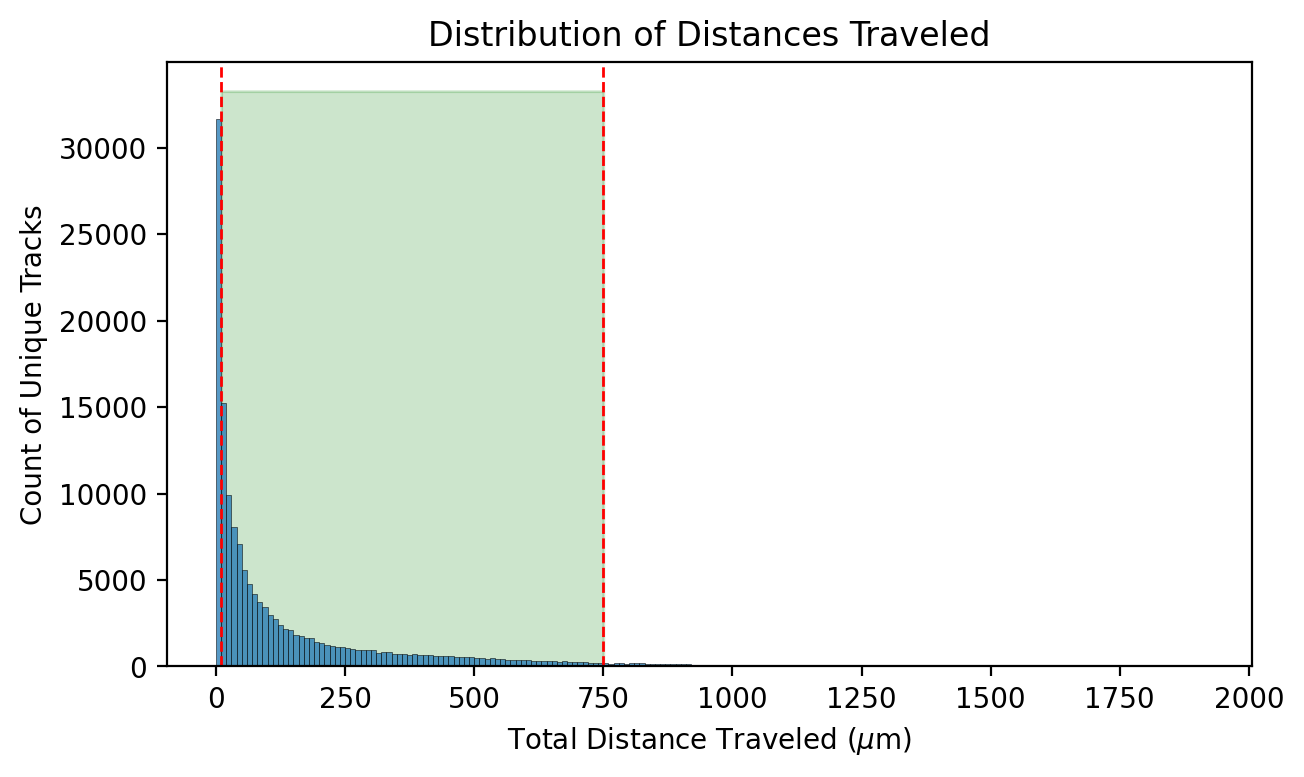

In [7]:
"""
cut the tracks below a certain length, or above a certain length
"""

MIN_CUT = 10
MAX_CUT = 750 

tmp = df[['TRACK_ID', 'TOTAL_DISTANCE_TRAVELED']].drop_duplicates()
print(tmp.shape, ' unique tracks')
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (7, 4)

sns.histplot(data=tmp,
             x='TOTAL_DISTANCE_TRAVELED',
             binwidth=10)

plt.ylabel('Count of Unique Tracks')
plt.xlabel(r'Total Distance Traveled ($\mu$m)')
plt.title("Distribution of Distances Traveled")

plt.axvline(x=MIN_CUT, ls='--', c='r', lw=1)
plt.axvline(x=MAX_CUT, ls='--', c='r', lw=1)
plt.fill_betweenx(list(range(0, int(plt.ylim()[1]))), 
                  MIN_CUT, 
                  MAX_CUT, 
                  color='g', 
                  alpha=0.2)

mask = (tmp['TOTAL_DISTANCE_TRAVELED'] > MIN_CUT) & (tmp['TOTAL_DISTANCE_TRAVELED'] < MAX_CUT)
tmp = tmp[mask]
print(tmp.shape, ' unique tracks')

Text(0.5, 1.0, 'Distribution of Distances Traveled')

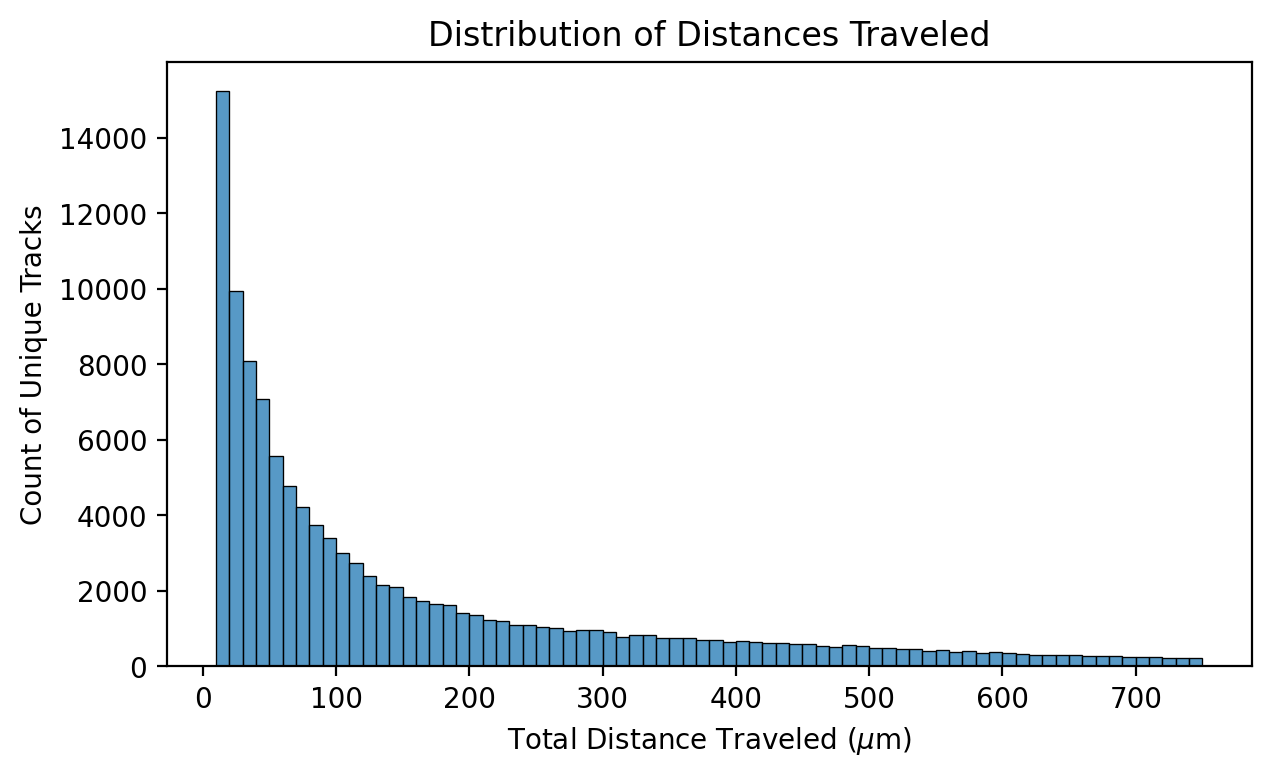

In [8]:
sns.histplot(data=tmp,
             x='TOTAL_DISTANCE_TRAVELED',
             binwidth=10)

plt.ylabel('Count of Unique Tracks')
plt.xlabel(r'Total Distance Traveled ($\mu$m)')
plt.title("Distribution of Distances Traveled")

In [9]:
"""
filter the original tracks based on TRACK_ID
"""

print(df.shape)
df = df[df['TRACK_ID'].isin(tmp['TRACK_ID'].unique())]
print(df.shape)


(4940523, 71)
(4142067, 71)


Text(0.5, 1.0, 'Distribution of Track Quality by Scene')

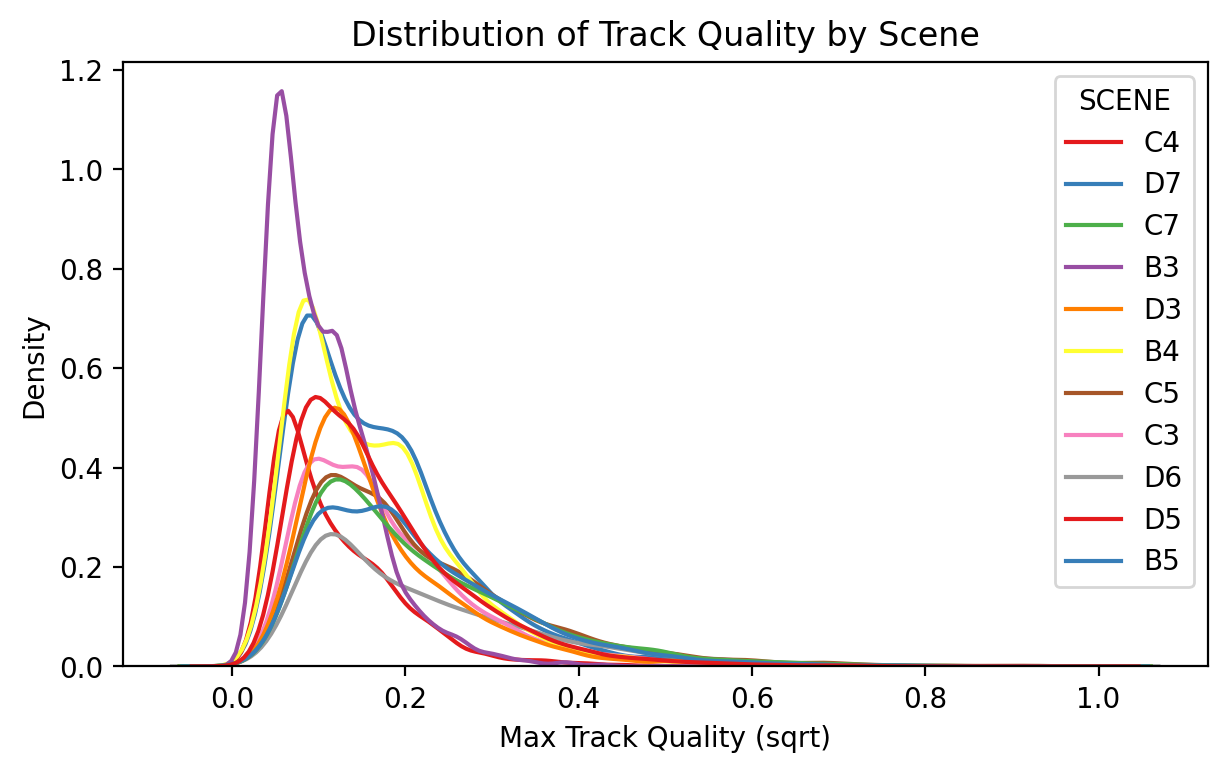

In [10]:
"""
look at track quality
"""

cols = [ 
    'TRACK_ID',
    'SCENE',
    'TRACK_MEAN_QUALITY',
    'TRACK_MAX_QUALITY',
    'TRACK_MIN_QUALITY',
    'TRACK_MEDIAN_QUALITY',
    'TRACK_STD_QUALITY'
]

tmp = df[cols].drop_duplicates()

tmp = _tm.min_max_norm(tmp, 'TRACK_MAX_QUALITY', 'SCENE')

tmp['qual'] = np.sqrt(tmp['TRACK_MAX_QUALITY_SCALED'])

sns.kdeplot(data=tmp,
            x='qual',
            hue='SCENE',
            palette='Set1')

plt.ylabel('Density')
plt.xlabel(r'Max Track Quality (sqrt)')
plt.title("Distribution of Track Quality by Scene")

In [11]:
stats = pd.DataFrame(tmp[[    'TRACK_MEAN_QUALITY',
    'TRACK_MAX_QUALITY',
    'TRACK_MIN_QUALITY',
    'TRACK_MEDIAN_QUALITY',
    'TRACK_STD_QUALITY']].describe())

stats = stats.round(3)
stats

,TRACK_MEAN_QUALITY,TRACK_MAX_QUALITY,TRACK_MIN_QUALITY,TRACK_MEDIAN_QUALITY,TRACK_STD_QUALITY
count,115592.000,115592.000,115592.000,115592.000,115592.000
mean,3.945,5.245,2.980,3.943,0.558
std,2.485,4.009,1.693,2.569,0.829
min,2.001,2.001,2.000,2.001,0.000
25%,2.456,2.943,2.056,2.428,0.179
50%,3.271,4.083,2.330,3.253,0.324
75%,4.470,5.963,3.207,4.450,0.639
max,78.169,187.167,34.750,100.762,55.419


In [12]:
"""
Filter out tracks whose max quality is very low
"""

MIN_CUT = 0.005

print(tmp.shape, ' unique tracks')
keep = tmp[tmp['TRACK_MAX_QUALITY_SCALED'] > MIN_CUT]
print(keep.shape, ' unique tracks')

df = df[df['TRACK_ID'].isin(keep['TRACK_ID'].unique())]
print(df.shape, ' total rows')

(115592, 9)  unique tracks
(100477, 9)  unique tracks
(4050720, 71)  total rows


Text(0.5, 1.0, 'Distribution of Mean Track SNR')

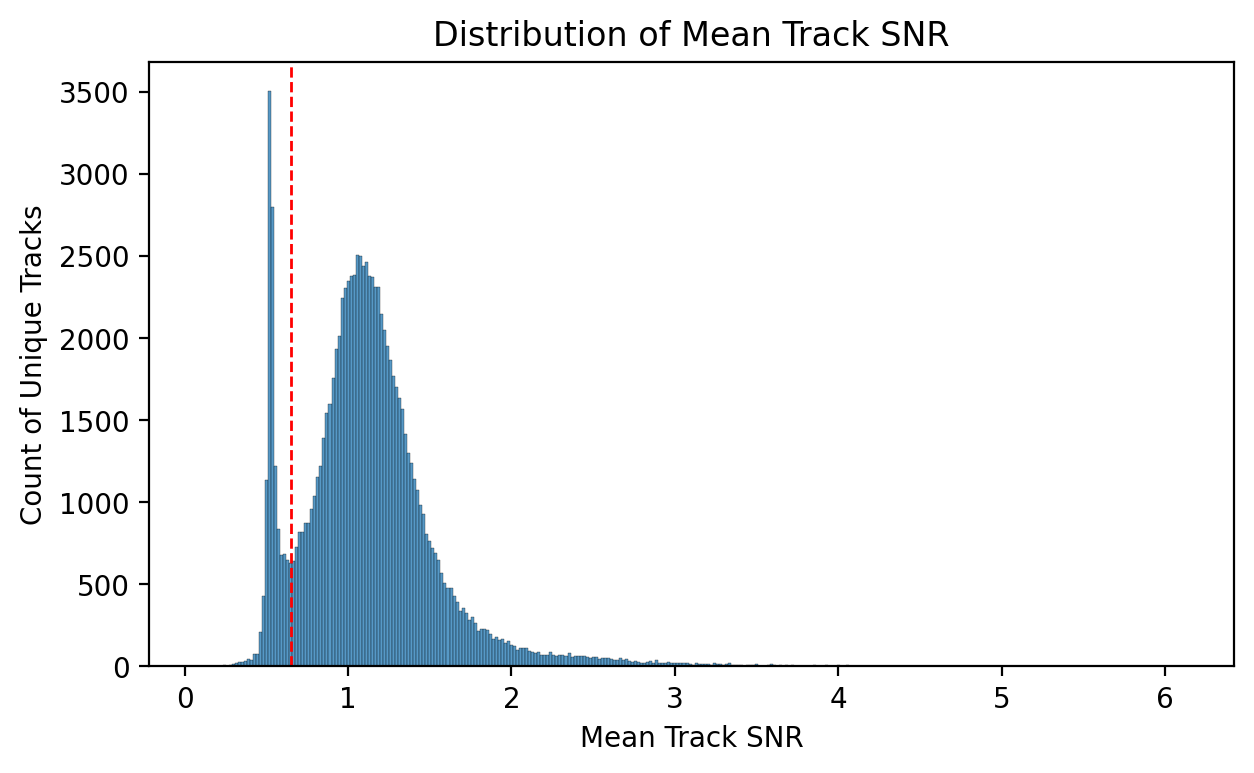

In [13]:
"""
look at track quality
"""
MIN_CUT = 0.65

cols = [ 
    'TRACK_ID',
    'SCENE',
    'SNR',
    'CONTRAST'
]

tmp = df[cols].drop_duplicates()

tmp = df.groupby('TRACK_ID', as_index=False).agg({'SCENE': 'first', 
                                                  'SNR':  ['mean', 'max', 'min', 'std']})
tmp.columns = ['_'.join(col).strip() for col in tmp.columns.values]
tmp.head()


sns.histplot(data=tmp,
            x='SNR_mean',
            palette='Set1')

plt.axvline(x=MIN_CUT, ls='--', c='r', lw=1)

plt.ylabel('Count of Unique Tracks')
plt.xlabel(r'Mean Track SNR')
plt.title("Distribution of Mean Track SNR")

In [14]:
MIN_CUT = 0.65

print(tmp.shape, ' unique tracks')
keep = tmp[tmp['SNR_mean'] > MIN_CUT]
print(keep.shape, ' unique tracks')

df = df[df['TRACK_ID'].isin(keep['TRACK_ID_'].unique())]
print(df.shape, ' total rows')

(100477, 6)  unique tracks
(87576, 6)  unique tracks
(3803486, 71)  total rows


### OUTPUT

In [15]:
# today = datetime.today().strftime('%Y-%m-%d')
# FILE_NAME = f"CLEANED_TRACKS{today}.csv"
FILE_NAME = f"CLEANED_TRACKS.csv"
save_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/analysis_files/"
full_path = f"{save_dir}{FILE_NAME}"
df.to_csv(full_path, index=False)

print(f"SAVED: {full_path}")

SAVED: /nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/analysis_files/CLEANED_TRACKS.csv
